# Maximum Likelihood and Logistic Regression

##### Keywords: maximum likelihood,  parametric model,  logistic regression, inference, backpropagation

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

$$
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\Cov}{\mathrm{Cov}}
\newcommand{\SampleAvg}{\frac{1}{N({S})} \sum_{s \in {S}}}
\newcommand{\indic}{\mathbb{1}}
\newcommand{\avg}{\overline}
\newcommand{\est}{\hat}
\newcommand{\trueval}[1]{#1^{*}}
\newcommand{\Gam}[1]{\mathrm{Gamma}#1}
$$

$$
\renewcommand{\like}{\cal L}
\renewcommand{\loglike}{\ell}
\renewcommand{\err}{\cal E}
\renewcommand{\dat}{\cal D}
\renewcommand{\hyp}{\cal H}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{\mathbf x}
\renewcommand{\v}[1]{\mathbf #1}
$$

## Logistic Regression MLE

Logistic regression if one of the well known **supervized** learning algorithms used for classification.

The idea behind logistic regression is very simple. We want to draw a line in feature space that divides the '1' samples from the '0' samples, just like in the diagram above. In other words, we wish to find the "regression" line which divides the samples. Now, a line has the form $w_1 x_1 + w_2 x_2 + w_0 = 0$ in 2-dimensions. On one side of this line we have 

$$w_1 x_1 + w_2 x_2 + w_0 \ge 0,$$

and on the other side we have 

$$w_1 x_1 + w_2 x_2 + w_0 < 0.$$ 

Our classification rule then becomes:

$$
\begin{eqnarray}
y = 1 &if& \v{w}\cdot\v{x} \ge 0\\
y = 0 &if& \v{w}\cdot\v{x} < 0
\end{eqnarray}
$$

where $\v{x}$ is the vector $\{1,x_1, x_2,...,x_n\}$ where we have also generalized to more than 2 features.

What hypotheses $h$ can we use to achieve this? One way to do so is to use the **sigmoid** function:

$$h(z) = \frac{1}{1 + e^{-z}}.$$

Notice that at $z=0$ this function has the value 0.5. If $z > 0$, $h > 0.5$ and as $z \to \infty$, $h \to 1$. If $z < 0$, $h < 0.5$ and as $z \to -\infty$, $h \to 0$. As long as we identify any value of $y > 0.5$ as 1, and any $y < 0.5$ as 0, we can achieve what we wished above.

This function is plotted below:

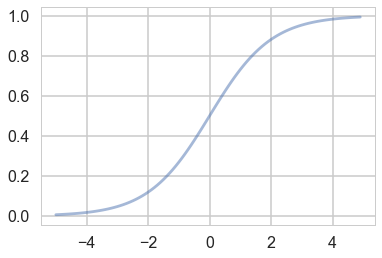

In [2]:
h = lambda z: 1./(1+np.exp(-z))
zs=np.arange(-5,5,0.1)
plt.plot(zs, h(zs), alpha=0.5);

So we then come up with our rule by identifying:

$$z = \v{w}\cdot\v{x}.$$

Then $h(\v{w}\cdot\v{x}) \ge 0.5$ if $\v{w}\cdot\v{x} \ge 0$ and $h(\v{w}\cdot\v{x}) \lt 0.5$ if $\v{w}\cdot\v{x} \lt 0$, and:

$$
\begin{eqnarray}
y = 1 &if& h(\v{w}\cdot\v{x}) \ge 0.5\\
y = 0 &if& h(\v{w}\cdot\v{x}) \lt 0.5.
\end{eqnarray}
$$

We said above that if $h > 0.5$ we ought to identify the sample with $y=1$? One way of thinking about this is to identify $h(\v{w}\cdot\v{x})$ with the probability that the sample is a '1' ($y=1$). Then we have the intuitive notion that lets identify a sample as 1 if we find that the probabilty of being a '1' is $\ge 0.5$.

So suppose we say then that the probability of $y=1$ for a given $\v{x}$ is given by $h(\v{w}\cdot\v{x})$?

Then, the conditional probabilities of $y=1$ or $y=0$ given a particular sample's features $\v{x}$ are:

$$\begin{eqnarray}
P(y=1 | \v{x}) &=& h(\v{w}\cdot\v{x}) \\
P(y=0 | \v{x}) &=& 1 - h(\v{w}\cdot\v{x}).
\end{eqnarray}$$

These two can be written together as

$$P(y|\v{x}, \v{w}) = h(\v{w}\cdot\v{x})^y \left(1 - h(\v{w}\cdot\v{x}) \right)^{(1-y)} $$

Then multiplying over the samples we get the probability of the training $y$ given $\v{w}$ and the $\v{x}$:

$$P(y|\v{x},\v{w}) = P(\{y_i\} | \{\v{x}_i\}, \v{w}) = \prod_{y_i \in \cal{D}} P(y_i|\v{x_i}, \v{w}) = \prod_{y_i \in \cal{D}} h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}$$

Why use probabilities? Earlier, we talked about how the regression function $f(x)$ never gives us the $y$ exactly, because of noise. This hold for classification too. Even with identical features, a different sample may be classified differently. 

We said that another way to think about a noisy $y$ is to imagine that our data $\dat$ was generated from  a joint probability distribution $P(x,y)$. Thus we need to model $y$ at a given $x$, written as $P(y \mid x)$, and since $P(x)$ is also a probability distribution, we have:

$$P(x,y) = P(y \mid x) P(x) ,$$

and can obtain our joint probability ($P(x, y))$.

Indeed its important to realize that a particular sample can be thought of as a draw from some "true" probability distribution. If for example the probability of classifying a sample point as a '0' was 0.1, and it turns out that the sample point was actually a '0', it does not mean that this model was necessarily wrong. After all, in roughly a 10th of the draws, this new sample would be classified as a '0'! But, of-course its more unlikely than its likely, and having good probabilities means that we'll be likely right most of the time, which is what we want to achieve in classification. 

Thus its desirable to have probabilistic, or at the very least, ranked models of classification where you can tell which sample is more likely to be classified as a '1'. 



Now if we maximize $$P(y \mid \v{x},\v{w})$$, we will maximize the chance that each point is classified correctly, which is what we want to do. This is a principled way of obtaining the highest probability classification. This **maximum likelihood** estimation maximises the **likelihood of the sample y**, 

$$\like = P(y \mid \v{x},\v{w}).$$ 


Again, we can equivalently maximize 

$$\loglike = log(P(y \mid \v{x},\v{w}))$$ 

since the natural logarithm $log$ is a monotonic function. This is known as maximizing the **log-likelihood**.


$$\loglike = log \like = log(P(y \mid \v{x},\v{w})).$$


Thus

$$\begin{eqnarray}
\loglike &=& log\left(\prod_{y_i \in \cal{D}} h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\
                  &=& \sum_{y_i \in \cal{D}} log\left(h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\                  
                  &=& \sum_{y_i \in \cal{D}} log\,h(\v{w}\cdot\v{x_i})^{y_i} + log\,\left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\\
                  &=& \sum_{y_i \in \cal{D}} \left ( y_i log(h(\v{w}\cdot\v{x_i})) + ( 1 - y_i) log(1 - h(\v{w}\cdot\v{x_i})) \right )
\end{eqnarray}$$

The negative of this log likelihood (henceforth abbreviated NLL), is also called the cross-entropy, for reasons that will become clearer soon.

$$ NLL = - \sum_{y_i \in \cal{D}} \left ( y_i log(h(\v{w}\cdot\v{x})) + ( 1 - y_i) log(1 - h(\v{w}\cdot\v{x})) \right )$$

We can calculate the gradient of this cost function, and the hessian as well.

$$\nabla_{\v{w}} NLL = \sum_i \v{x_i}^T (p_i - y_i) = \v{X}^T \cdot ( \v{p} - \v{w} )$$

$$H = \v{X}^T diag(p_i (1 - p_i))\v{X}$$ which is positive definite, making the cross-entropy loss convex with a global minimum.

Logistic regression can be represented by the following diagram. This diagram uses the language of "units". A linear unit is followed by a non-linear sigmoidal squashing unit, or more precisely a log-sigmoidal squashing unit which is then used to construct the cross-entropy loss.

![](images/layershorstd.png)

## Softmax formulation

The softmax formulation of logistic regression comes from the desire togeneralize logistic regression to the multinomial case, that is more than 2 classes. Its instructive to see the two-class problem formulated in softmax as well.

The basic idea is to identify the probabilities $p_i$ and $1-p_i$ as two separate probabilities which are constrained to add to 1. That is

$$p_{1i} = p_i ; p_{2i} = 1 - p_i. $$

Then, the function $h$ which is used to supply this probability can be reformulated as well:

$$p_{1i} = \frac{e^{\v{w_1} \cdot \v{x}}}{e^{\v{w_1} \cdot \v{x}} + e^{\v{w_2} \cdot \v{x}}}$$

and 

$$p_{2i} = \frac{e^{\v{w_2} \cdot \v{x}}}{e^{\v{w_1} \cdot \v{x}} + e^{\v{w_2} \cdot \v{x}}}$$

The constraint that these probabilities add to 1 is clearly satisfied, but notice that we now have double the number of parameters we had before. We can obtain the old interpretation of $p_{1i}$ by multiplying both the numerator and denominator by $e^{-\v{w_1} \cdot \v{x}}$.

This then identifies $\v{w} = \v{w_1} - \v{w_2}$. In general, we can see that we can always translate the coefficients by a fixed amount $\psi$ without any change. This leads to a lack of "identification" of the parameters in the softmax formalism, which leads to problems for inference that we must fix. On the plus side, it also suggests a way to calculate softmax in a stable way (see the log-sum-exp trick). We'll tackle both of these later.

The softmax formulation of logistic regression can be illustrated using the following diagram, where we now have 2 linear units. These units are now fed into a nonlinear log-softmax unit (which requires outputs of both the linear units) to produce two log-softmax outputs which is then fed to the NLL loss (cross-entropy).

![](images/layershorsm.png)

In this formalism, we can write the likelihood and thus NLL more succintly:

$$\like = \prod_i p_{1i}^{\mathbb1_1(y_i)} p_{2i}^{\mathbb1_2(y_i)}$$

$$NLL = -\sum_i \left( \mathbb1_1(y_i) log(p_{1i}) + \mathbb1_2(y_i) log(p_{2i}) \right)$$

We are now left with 2 gradients (or a combined gradient if you combine both $\v{w_1}$ and $\v{w_2}$ into one vector:

$$\frac{\partial NLL}{\partial \v{w_1}} = -\sum_i \v{x_i} (y_i - p_{1i})$$

and

$$\frac{\partial NLL}{\partial \v{w_2}} = -\sum_i \v{x_i} (y_i - p_{2i})$$

## Layer Structure

Writing the $NLL$ slightly differently suggests a layer structure:

$$NLL = -\sum_i \left( \mathbb1_1(y_i) log(SM_1(\v{w_1} \cdot \v{x}, \v{w_2} \cdot \v{x})) + \mathbb1_2(y_i) log(SM_2(\v{w_1} \cdot \v{x}, \v{w_2} \cdot \v{x})) \right)$$

$$NLL = -\sum_i \left( \mathbb1_1(y_i) LSM_1(\v{w_1} \cdot \v{x}, \v{w_2} \cdot \v{x}) + \mathbb1_2(y_i) LSM_2(\v{w_1} \cdot \v{x}, \v{w_2} \cdot \v{x}) \right)$$

where $SM_1 = \frac{e^{\v{w_1} \cdot \v{x}}}{e^{\v{w_1} \cdot \v{x}} + e^{\v{w_2} \cdot \v{x}}}$ puts the first argument in the numerator. Ditto for $LSM_1$ which is simply $log(SM_1)$.

The layer structure suggested is captured in the diagram below. There are 4 layers, which we shall generally label using the notation $\v{z}^l$ where the vector on $z$ indicates multiple values and the $l$ indicates the number of the layer (it is NOT a power).

![](images/layershororig.png)

First, the input:

$$\v{z}^1 = \v{x_i}$$

Notice here that we are writing this data-point by data-point. We will follow this structure for everything but the cost function. The dimension of this $\v{z}^1$ depends on the number of features $\v{x_i}$ has.


Then, the second layer.

$$\v{z}^2 = (z^2_1, z^2_2) = (\v{w_1} \cdot \v{x_i}, \v{w_2} \cdot \v{x_i}) = (\v{w_1} \cdot \v{z^1_i}, \v{w_2} \cdot \v{z^1_i})$$

The dimension of $\v{z}^2$ is 2 corresponding to the two linear layers.

Then the third layer is also two dimensional, corresponding to the 2 log-softmax functions we have.

$$\v{z}^3 = (z^3_1, z^3_2) = \left( LSM_1(z^2_1, z^2_2), LSM_2(z^2_1, z^2_2) \right)$$

Finally, the fourth layer is just the cost layer, and is actually a scalar.

$$z^4 = NLL(\v{z}^3) = NLL(z^3_1, z^3_2) = - \sum_i \left( \mathbb1_1(y_i)z^3_1(i) + \mathbb1_2(y_i)z^3_1(i) \right)$$

Notice how these expressions are different from the fully expanded expressions we had earlier. Here each layer only depends on the previous layer. We shall utilize this structure soon to make our lives easier. Our tool to do this is **backpropagation**, which is just an example of Reverse Mode differentiation, which as can be surmised from the above structure, is a matter of taking derivatives by substitution, but in a particular order.

## Reverse Mode Differentiation

We wont go into many details, but the key observation is this. An operation like finding the loss in our logistic regression problem can be considered as an exercise in function composition, where the last function ($z^4$, or the NLL cost) is a scalar. In other words, we are wanting to calculate:

$$Cost = f^{Loss}(\v{f}^3(\v{f}^2(\v{f}^1(\v{x}))))$$

where the vectorial function or the $\v{x}$ is a short form notation for both data and parameters. for this expression.  Now, for gradient-descent, when i want to calculate the derivative or gradient with respect to data/parameters $\v{x}$, i can write:

$$\nabla_{\v{x}} Cost = \frac{\partial f^{Loss}}{\partial \v{f}^3}\,\frac{\partial \v{f}^3}{\partial \v{f}^2}\,\frac{\partial \v{f}^2}{\partial \v{f}^1}\frac{\partial \v{f}^1}{\partial \v{x}}$$

Now, based on the observation that the first term in the above product is a vector while the second is a (Jacobian!) matrix, we can consider rewriting the product in this fashion:

$$\nabla_{\v{x}} Cost = (((\frac{\partial f^{Loss}}{\partial \v{f}^3}\,\frac{\partial \v{f}^3}{\partial \v{f}^2})\,\frac{\partial \v{f}^2}{\partial \v{f}^1})\,\frac{\partial \v{f}^1}{\partial \v{x}})$$

This way of writing things always provides us with a vector times a matrix giving us a vector and saves a huge amount of memory, especially on large problems. This is the key idea of reverse mode auto diff.

Backpropagation falls easily out of this. We add a "cost layer" to $z^4$. The derivative of this layer with respect to $z^4$ will always be 1. We then propagate this derivative back.

## Backpropagation

Everything comes together now. Let us illustrate with a diagram:

![](images/layercake.png)

We can consider our calculations to now consist of two phases: a forward phase, and a backward phase.

In the forward phase, all we are doing is function composition, in the old fashioned way, starting from the bottom-most $\vec{x_i}$ later, and moving up the layer cake to the cost. (Notice how this is just `.forward` in pytorch.)

RULE1: FORWARD

$$\v{z}^{l+1} = \v{f}^l (\v{z}^l)$$

In the reverse or backward phase, we now propagate the derivatives backward through the layer cake (pytoych: `.backward`). By derivatives we mean:

$$\v{\delta^l} = \frac{\partial C}{\partial \v{z}^l}$$

or (u for unit}

$$\delta^l_u = \frac{\partial C}{\partial z^l_u}$$.

And the formula for this now is very simple, as we will do it iteratively as in reverse-mode differentiation.

RULE2: BACKWARD

$$\delta^l_u = \frac{\partial C}{\partial z^l_u} = \sum_v \frac{\partial C}{\partial z^{l+1}_v} \, \frac{\partial z^{l+1}_v}{\partial z^l_u} = \sum_v \delta^{l+1}_v \, \frac{\partial z^{l+1}_v}{\partial z^l_u} $$



Once again the first term in the product is obviously a vector, and the second term a matrix, so we can recursively get the derivatives all the way down. So this gives us the compositional derivative at any depth we want. In particular we will start with

$$\delta^3_u = \frac{\partial z^{4}}{\partial z^3_u} = \frac{\partial C}{\partial z^3_u}$$

which is now simply a derivative of the NLL with respect to "dummy" variables representing the LSM functions.



One formula remains: the derivatives with respect to any parameter in any layer. In our case we have the $\vec{w}$ parameters at level-2, but these could be parameters at a higher level as well. For them we have

RULE 3: Parameters

$$\frac{\partial C}{\partial \theta^l} = \sum_u \frac{\partial C}{\partial z^{l+1}_u} \, \frac{\partial z^{l+1}_u}{\partial \theta^l} = \sum_u \delta^{l+1}_u \frac{\partial z^{l+1}_u}{\partial \theta^l}$$

Another recursion! Uses the derivatives we calculate in the backward pass. Both those derivates and these are used to fill the `variable.grad` parts of the various parameters in pytorch. This is also the reason for the strange choice to hold the gradients along with the variables rather than with the cost: we back propagate those gradients into the variables, so to speak.

## Coding a layer

This extreme modularity suggests that we can define our own layers (or recursively, even our own combination of layers). even though we wont want to do this for logistic regression, this functionality is useful in defining Artificial Neural Network architectures.

What we must specifically provide is a way to implement the 3 rules for a layer: how to get output $z$ given input $z$, how to get reverse output $\delta$s given input ones, and how to differentiate the cost with respect to any local parameters.

![](images/layerl.png)

Such modularity allows for lots of experimentation.